In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
import pandas as pd
tstart=time.time()
import matplotlib.pyplot as plt 
from tabulate import tabulate

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,              type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',          type=str,     help='gpu id')
parser.add_argument('--experiment',         default='16_task_groups',       type =str,    help='Mnist or dissertation')
parser.add_argument('--approach',           default='PUGCL',          type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--data_path',          default='data/data_test.csv',     type=str,     help='gpu id')

# Training parameters
parser.add_argument('--output',             default='',             type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints_16_tasks',    type=str,   help='')
parser.add_argument('--n_epochs',           default=100,              type=int,     help='')
parser.add_argument('--batch_size',         default=64,             type=int,     help='')
parser.add_argument('--lr',                 default=0.03,           type=float,   help='')
parser.add_argument('--hidden_size',        default=800,           type=int,     help='')
parser.add_argument('--parameter',          default='',             type=str,     help='')

# UCB HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default=1,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
utils.print_arguments(args)

Arguments =
	seed: 0
	device: cpu
	experiment: 16_task_groups
	approach: PUGCL
	data_path: data/data_test.csv
	output: 
	checkpoint_dir: ../checkpoints_16_tasks
	n_epochs: 100
	batch_size: 64
	lr: 0.03
	hidden_size: 800
	parameter: 
	MC_samples: 10
	rho: -3.0
	sigma1: 0.0
	sigma2: 6.0
	pi: 0.25
	resume: no
	sti: 1
	fff: /Users/jonastjomsland/Library/Jupyter/runtime/kernel-070573f8-9376-4ae0-b533-88a152f00442.json


In [4]:
# Set seed for stable results
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Check if Cuda is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Using device:", args.device)

# PUGCL with two tasks:
from data import dataloader_16_tasks as dataloader

# Import Lifelong Uncertainty-aware Learning approach:
from training_method import PUGCL

#from bayesian_model.bayesian_network import BayesianNetwork
from bayesian_model.bayesian_network import BayesianNetwork

# Load training data:
print("Loading data...")
data, task_outputs, input_size = dataloader.get(data_path='data/data.csv')
print("Input size =", input_size, "\nTask info =", task_outputs)
print("Number of data samples: ", len(data[0]['train']['x']))
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs
# Checkpoint
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint
print()

# Initialize Bayesian network
print("Initializing network...")
model = BayesianNetwork(args).to(args.device)

# Initialize Lul approach
print("Initialize Lifelong Uncertainty-aware Learning")
approach = PUGCL(model, args=args)
print("-"*100)

# Load stored model:
model_number = 8
checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(model_number)), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device=args.device).eval()

Using device: cpu
Loading data...
Input size = [1, 29] 
Task info = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2)]
Number of data samples:  500
16_task_groups_PUGCL
Results will be saved in  ../checkpoints_16_tasks/16_task_groups_PUGCL

Initializing network...
Initialize Lifelong Uncertainty-aware Learning
----------------------------------------------------------------------------------------------------


In [5]:
# Load features:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]

features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]
features['Stamp'] = features['Stamp'].astype(int)

In [6]:
# Load test data:
full_set = pd.read_csv(args.data_path)
full_set['Stamp'] = full_set['Stamp'].astype(int)
# Split in circle and arrow
df_circle = full_set[full_set['Using circle'] == 1]
df_arrow = full_set[full_set['Using circle'] == 0]
actions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]

In [7]:
# Do 100 MC samples of inference for circle part
x_circle = torch.tensor(df_circle.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
x_arrow = torch.tensor(df_arrow.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
test_scenes = [[df_circle.iloc[:,0:30].drop_duplicates().Stamp.values][0], [df_arrow.iloc[:,0:30].drop_duplicates().Stamp.values][0]]
# Dict with numpy arrays of outputs:
model_output = {}
first_it = True
for sample in range(100):
    output_circle = model(x_circle[:,1:], sample = True)
    output_arrow = model(x_arrow[:,1:], sample = True)
    # Append output
    # Circle actions
    for i, action in enumerate(actions[0]):
        if first_it:
            model_output[i] = output_circle[i].detach().numpy()
        else:
            model_output[i] = np.dstack([model_output[i],output_circle[i].detach().numpy()])
    # Arrow actions
    for i, action in enumerate(actions[1]):
        if first_it:
            model_output[i+8] = output_arrow[i+8].detach().numpy()
        else:
            model_output[i+8] = np.dstack([model_output[i+8],output_arrow[i+8].detach().numpy()])
    first_it = False

In [8]:
evaluation_dict = {}
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        evaluation_dict[scene] = {}
        # Scene stamp for image
        evaluation_dict[scene]['Stamp'] = scene
        
        # Features of the scene
        evaluation_dict[scene]['Features'] = features[features.Stamp == scene].values[0][2:].astype(float)
        # Actions for that scene
        evaluation_dict[scene]['Actions'] = actions[int(evaluation_dict[scene]['Features'][1])]
        
        # Using circle or arrow
        if evaluation_dict[scene]['Features'][0] == 1:
            # Scene is with circle
            evaluation_dict[scene]['Using circle'] = True
            scene_df = df_circle[df_circle.Stamp == scene]
        else:
            evaluation_dict[scene]['Using circle'] = False
            scene_df = df_arrow[df_arrow.Stamp == scene]
        
        # Labeled answers
        evaluation_dict[scene]['Mean label'] = scene_df.mean(axis = 0).values[30:]
        evaluation_dict[scene]['Variance in labels'] = scene_df.var(axis = 0).values[30:]
        
        # Predicted values:
        evaluation_dict[scene]['Predicted mean'] = []
        evaluation_dict[scene]['Aleatoric uncertainty'] = []
        evaluation_dict[scene]['Epistemic uncertainty'] = []
        # Iterate over actions:
        for i in range(8):
            if evaluation_dict[scene]['Features'][0] == 0:
                i += 8
            mean = model_output[i][scene_index, 0, :]
            variance = np.exp(model_output[i][scene_index ,1,:])
            # Append predictive mean
            evaluation_dict[scene]['Predicted mean'].append(np.mean(mean))
            # Append Aleatoric
            evaluation_dict[scene]['Aleatoric uncertainty'].append(np.mean(variance))
            # Append Epistemic
            evaluation_dict[scene]['Epistemic uncertainty'].append(np.mean(np.square(mean)) - np.square(np.mean(mean)))
            
        # Put everything into a table for that scene:
        evaluation_dict[scene]['Table'] = [evaluation_dict[scene]['Actions'], evaluation_dict[scene]['Mean label'], evaluation_dict[scene]['Variance in labels'], evaluation_dict[scene]['Predicted mean'], evaluation_dict[scene]['Aleatoric uncertainty'], evaluation_dict[scene]['Epistemic uncertainty']]
        

Scene number: 353


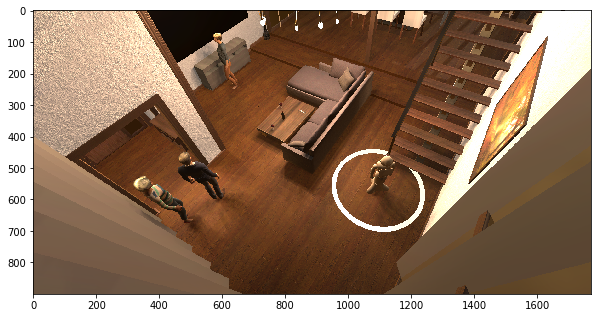

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,4.000,1.428571,2.422728,1.601590,0.601152
Mopping the floor,4.000,1.714286,1.941999,1.436421,0.525162
Carry warm food,3.375,1.696429,2.341452,1.007554,0.519872
Carry cold food,3.750,1.642857,2.339301,1.540228,0.507565
Carry drinks,3.625,1.410714,2.511710,1.149180,0.433893
"Carry small objects (plates, toys)",4.375,0.553571,2.124661,1.245841,0.516698
"Carry big objects (tables, chairs)",3.250,2.214286,2.878008,1.923953,0.563435
Cleaning (Picking up stuff),4.625,0.267857,3.827472,1.559117,0.481783


Scene number: 771


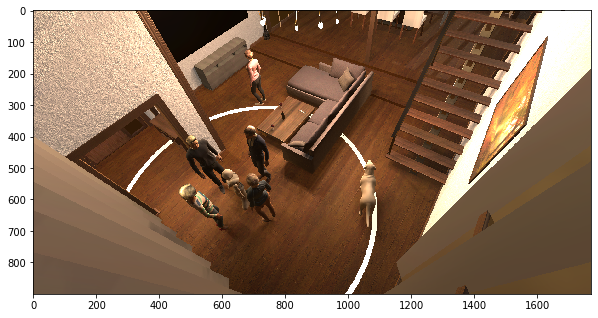

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,1.428571,0.263736,1.688824,1.957453,0.897602
Mopping the floor,1.428571,0.263736,2.660836,2.956045,1.043375
Carry warm food,2.571429,2.109890,2.235046,1.934680,0.811248
Carry cold food,2.714286,1.912088,2.143340,1.796769,0.799478
Carry drinks,2.642857,1.939560,2.014408,2.365119,0.835667
"Carry small objects (plates, toys)",2.142857,1.208791,2.347462,2.055423,1.059372
"Carry big objects (tables, chairs)",1.571429,0.725275,1.823842,2.045345,1.062321
Cleaning (Picking up stuff),1.857143,1.054945,2.816276,2.097144,1.028768


Scene number: 897


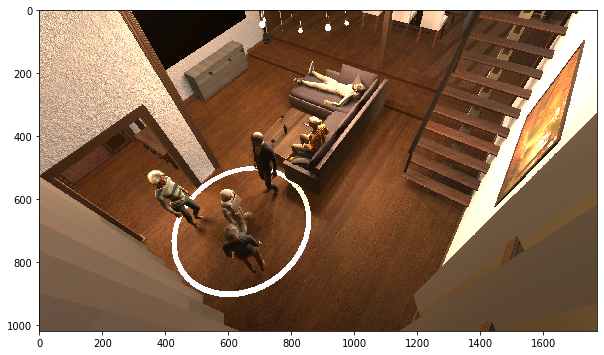

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,1.583333,0.446970,1.609659,1.569837,0.787997
Mopping the floor,1.666667,0.787879,1.947752,1.956759,0.992982
Carry warm food,3.833333,1.060606,2.085413,2.244840,0.636154
Carry cold food,3.833333,1.060606,1.698283,2.111960,0.741371
Carry drinks,3.750000,1.295455,2.249316,1.493154,0.825945
"Carry small objects (plates, toys)",3.750000,1.477273,2.129908,1.433762,0.726215
"Carry big objects (tables, chairs)",1.333333,0.242424,1.979092,1.784780,0.730203
Cleaning (Picking up stuff),3.416667,1.537879,2.539341,1.226180,0.805507


Scene number: 812


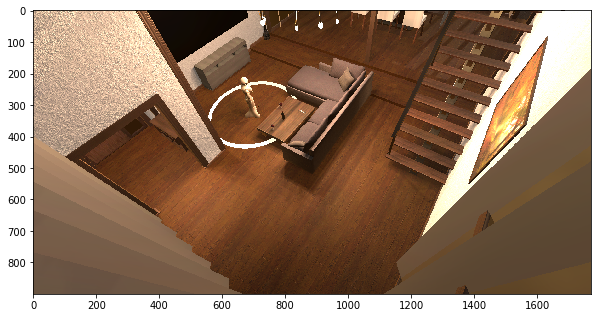

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,4.461538,1.269231,2.708337,2.875363,1.292622
Mopping the floor,4.538462,1.269231,3.380487,2.191003,1.475252
Carry warm food,2.769231,3.192308,2.982219,1.712001,1.231180
Carry cold food,2.769231,3.192308,3.060427,1.343249,1.248928
Carry drinks,2.769231,3.192308,2.726321,1.614241,1.054632
"Carry small objects (plates, toys)",3.769231,2.358974,3.360064,2.107198,1.518946
"Carry big objects (tables, chairs)",3.846154,1.974359,4.167489,3.122293,1.494801
Cleaning (Picking up stuff),4.384615,1.756410,3.949446,2.106440,1.376381


Scene number: 833


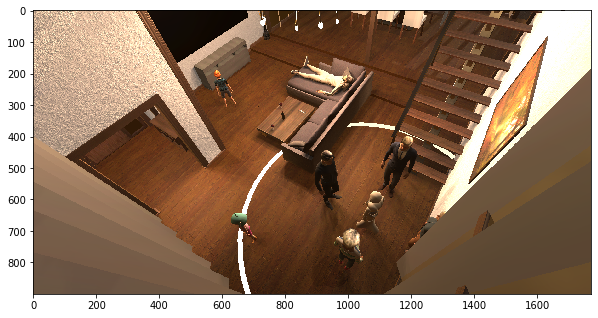

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,2.083333,1.174242,2.062265,1.883347,1.101214
Mopping the floor,2.250000,1.113636,2.095974,2.651605,1.048384
Carry warm food,2.750000,1.113636,2.494026,2.818054,0.654255
Carry cold food,3.083333,1.719697,1.498033,2.396485,0.943222
Carry drinks,3.083333,1.719697,2.679679,1.728515,0.970963
"Carry small objects (plates, toys)",3.166667,1.424242,2.141558,1.484936,1.023918
"Carry big objects (tables, chairs)",2.083333,1.356061,1.671504,1.221571,1.169948
Cleaning (Picking up stuff),2.833333,1.242424,2.540354,1.389764,0.927144


Scene number: 968


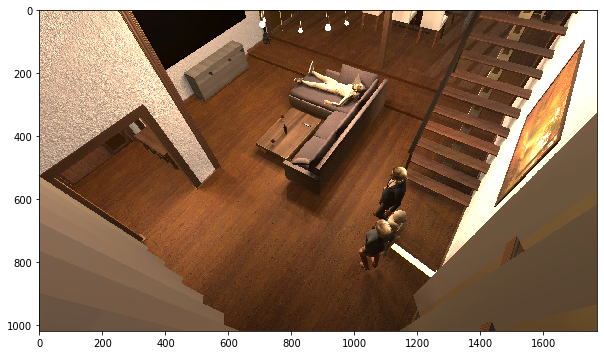

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,1.7500,0.600000,3.215735,2.116360,0.424800
Mopping the floor,2.6250,1.850000,0.155200,0.871809,0.568781
Carry warm food,3.5625,0.929167,1.201791,1.833706,0.717894
Carry cold food,3.5625,0.929167,1.053388,1.124198,0.628068
Carry drinks,3.5625,0.795833,2.166810,2.224645,0.609029
"Carry small objects (plates, toys)",3.6875,0.762500,1.233887,1.578181,0.427584
"Carry big objects (tables, chairs)",2.6875,1.429167,2.229184,1.340547,0.668417
Starting conversation,3.0000,1.333333,1.883464,2.744066,0.418315


Scene number: 836


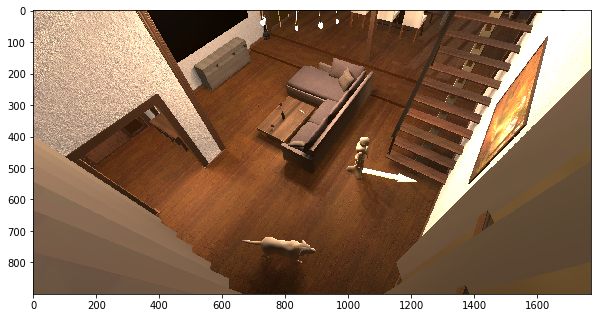

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,3.785714,2.027473,3.401748,4.691732,1.314567
Mopping the floor,3.785714,1.719780,0.170148,1.667048,1.402234
Carry warm food,2.857143,2.131868,0.671037,1.442374,1.115520
Carry cold food,3.071429,2.379121,1.866783,1.739722,1.503954
Carry drinks,2.928571,2.071429,2.686812,4.787069,1.129775
"Carry small objects (plates, toys)",3.428571,1.802198,2.487929,5.418290,1.384915
"Carry big objects (tables, chairs)",3.357143,1.170330,2.324511,1.315248,1.280719
Starting conversation,1.642857,1.631868,2.824484,5.938666,1.409383


Scene number: 735


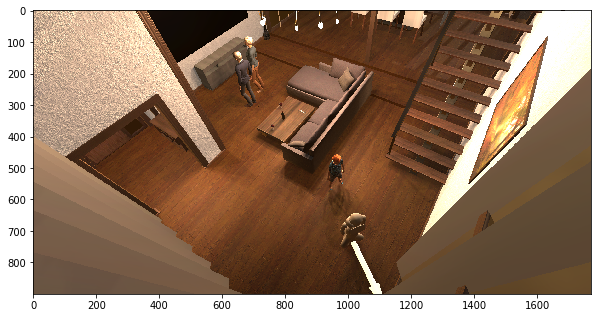

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,3.600000,1.542857,2.930317,2.413703,0.450010
Mopping the floor,4.000000,1.285714,-0.198478,1.059279,0.607173
Carry warm food,3.000000,2.142857,1.240794,1.351587,0.753926
Carry cold food,3.133333,2.266667,1.561118,1.777133,0.565494
Carry drinks,3.066667,2.209524,2.214825,2.817971,0.753034
"Carry small objects (plates, toys)",3.866667,1.123810,0.710346,0.916961,0.490666
"Carry big objects (tables, chairs)",3.133333,1.695238,1.840560,1.320200,0.743373
Starting conversation,2.533333,1.552381,1.577430,2.213382,0.501576


Scene number: 315


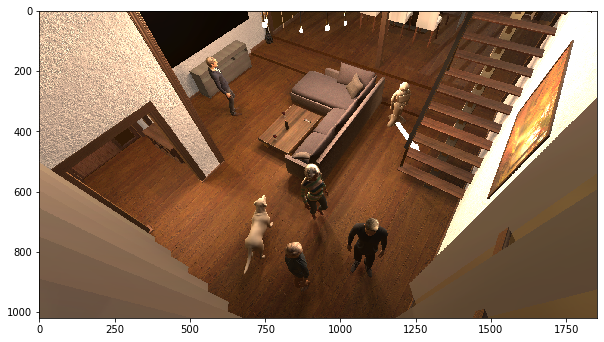

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,2.666667,1.666667,3.529747,2.474338,0.714055
Mopping the floor,2.666667,1.952381,0.619949,1.544831,0.632997
Carry warm food,2.600000,1.971429,1.450008,2.249093,0.769137
Carry cold food,2.600000,1.971429,0.362256,1.635074,0.858286
Carry drinks,2.600000,1.971429,1.944246,1.212638,0.808503
"Carry small objects (plates, toys)",3.000000,1.428571,1.589594,1.337890,0.713049
"Carry big objects (tables, chairs)",2.066667,1.495238,1.818316,1.625604,0.809814
Starting conversation,2.533333,1.552381,2.330103,2.039278,0.778396


Scene number: 803


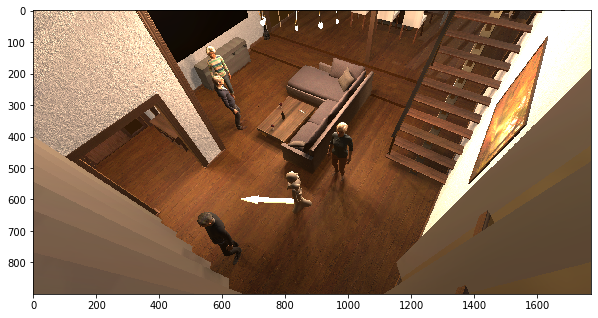

,Mean label,Variance in labels,Predicted mean,Aleatoric uncertainty,Epistemic uncertainty
Actions,,,,,
Vacuum cleaning,2.538462,1.269231,3.483151,2.231319,0.682624
Mopping the floor,3.000000,1.333333,0.135891,4.132419,0.861068
Carry warm food,3.076923,1.076923,1.135744,1.672116,1.006395
Carry cold food,3.076923,1.076923,1.425464,2.418887,0.933074
Carry drinks,3.076923,1.076923,2.058723,2.809028,0.738217
"Carry small objects (plates, toys)",3.384615,0.589744,1.576804,2.676389,0.588558
"Carry big objects (tables, chairs)",2.692308,0.564103,1.540270,3.392683,0.985319
Starting conversation,3.000000,1.500000,2.397312,3.468304,0.765784


In [9]:
# Print evaluation along with image
counter = 0
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        print('Scene number:', scene)
        # Print image
        if features.loc[features['Stamp'] == scene].empty:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(scene)]['File Path'].values[0]
        else:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == scene]['File Path'].values[0]
        img = plt.imread(image_path)
        plt.figure(figsize = (10,12))
        plt.rcParams["axes.grid"] = False
        imgplot = plt.imshow(img)
        plt.show()
        # Create dataframe to view results:
        eval_df = pd.DataFrame(columns= ['Mean label', 'Variance in labels', 'Predicted mean', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        for column in eval_df:
            eval_df[column] = evaluation_dict[scene][column]
        eval_df.index = evaluation_dict[scene]['Actions']
        eval_df.index.name = 'Actions'
        display(eval_df)
        counter += 1
        if counter > 4:
            counter = 0
            break